# Programming Exercise 3
# Multi-class Classification and Neural Networks

## Introduction


In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize handwritten digits. Before starting the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics. 

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. The assignment can be promptly submitted to the coursera grader directly from this notebook (code and instructions are included below).

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools. You can find instructions on how to install required libraries in the README file in the [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## Submission and Grading


After completing each part of the assignment, be sure to submit your solutions to the grader. The following is a breakdown of how each part of this exercise is scored.


| Section | Part                                 | Submission function                   |  Points 
| :-      |:-                                    | :-                                    |  :-:    
| 1       | [Regularized Logistic Regression](#section1)     | [`lrCostFunction`](#lrCostFunction)   | 30     
| 2       | [One-vs-all classifier training](#section2)       | [`oneVsAll`](#oneVsAll)               | 20     
| 3       | [One-vs-all classifier prediction](#section3)     | [`predictOneVsAll`](#predictOneVsAll) | 20     
| 4       | [Neural Network Prediction Function](#section4)   | [`predict`](#predict)           | 30
|         | Total Points                         |                                 | 100    


You are allowed to submit your solutions multiple times, and we will take only the highest score into consideration.

<div class="alert alert-block alert-warning">
At the end of each section in this notebook, we have a cell which contains code for submitting the solutions thus far to the grader. Execute the cell to see your score up to the current section. For all your work to be submitted properly, you must execute those cells at least once. They must also be re-executed everytime the submitted function is updated.
</div>

## 1 Multi-class Classification

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you have learned can be used for this classification task.

In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.

### 1.1 Dataset

You are given a data set in `ex3data1.mat` that contains 5000 training examples of handwritten digits (This is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist) handwritten digit dataset). The `.mat` format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. We use the `.mat` format here because this is the dataset provided in the MATLAB version of this assignment. Fortunately, python provides mechanisms to load MATLAB native format using the `loadmat` function within the `scipy.io` module. This function returns a python dictionary with keys containing the variable names within the `.mat` file. 

There are 5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 
We start the exercise by first loading the dataset. Execute the cell below, you do not need to write any code here.

In [3]:
# 20x20 Input Images of Digits
input_layer_size  = 400

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

m = y.size

### 1.2 Visualizing the data

You will begin by visualizing a subset of the training set. In the following cell, the code randomly selects selects 100 rows from `X` and passes those rows to the `displayData` function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together. We have provided the `displayData` function in the file `utils.py`. You are encouraged to examine the code to see how it works. Run the following cell to visualize the data.

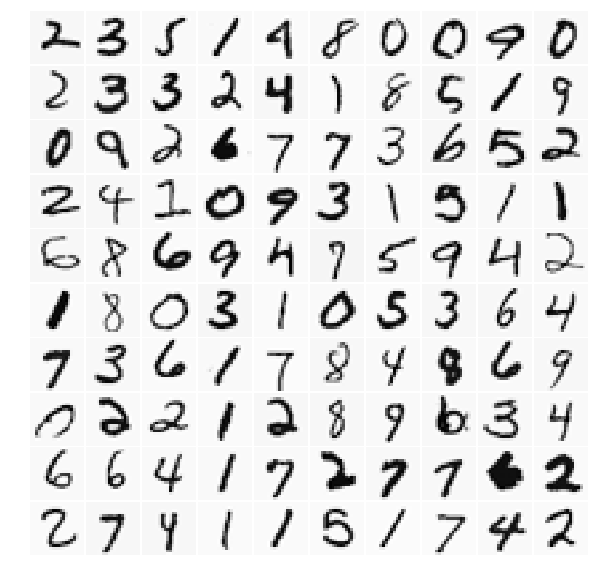

In [4]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### 1.3 Vectorizing Logistic Regression

You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any `for` loops. You can use your code in the previous exercise as a starting point for this exercise. 

To test your vectorized logistic regression, we will use custom data as defined in the following cell.

In [5]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

<a id="section1"></a>
#### 1.3.1 Vectorizing the cost function 

We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

To compute each element in the summation, we have to compute $h_\theta(x^{(i)})$ for every example $i$, where $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $\theta$ as

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Then, by computing the matrix product $X\theta$, we have: 

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

In the last equality, we used the fact that $a^Tb = b^Ta$ if $a$ and $b$ are vectors. This allows us to compute the products $\theta^T x^{(i)}$ for all our examples $i$ in one line of code.

#### 1.3.2 Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$,

$$
\begin{align*}
\begin{bmatrix} 
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

where

$$  h_\theta(x) - y = 
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

Note that $x^{(i)}$ is a vector, while $h_\theta\left(x^{(i)}\right) - y^{(i)}$  is a scalar (single number).
To understand the last step of the derivation, let $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ and
observe that:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

where the values $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

The expression above allows us to compute all the partial derivatives
without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. 

Your job is to write the unregularized cost function `lrCostFunction` which returns both the cost function $J(\theta)$ and its gradient $\frac{\partial J}{\partial \theta}$. Your implementation should use the strategy we presented above to calculate $\theta^T x^{(i)}$. You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of `lrCostFunction` should not contain any loops.

<div class="alert alert-box alert-warning">
**Debugging Tip:** Vectorizing code can sometimes be tricky. One common strategy for debugging is to print out the sizes of the matrices you are working with using the `shape` property of `numpy` arrays. For example, given a data matrix $X$ of size $100 \times 20$ (100 examples, 20 features) and $\theta$, a vector with size $20$, you can observe that `np.dot(X, theta)` is a valid multiplication operation, while `np.dot(theta, X)` is not. Furthermore, if you have a non-vectorized version of your code, you can compare the output of your vectorized code and non-vectorized code to make sure that they produce the same outputs.
</div>
<a id="lrCostFunction"></a>

In [14]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Computes the cost of using theta as the parameter for regularized
    logistic regression and the gradient of the cost w.r.t. to the parameters.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept.  
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (including intercept).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to the cost.
    Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta
    
    Hint 1
    ------
    The computation of the cost function and gradients can be efficiently
    vectorized. For example, consider the computation
    
        sigmoid(X * theta)
    
    Each row of the resulting matrix will contain the value of the prediction
    for that example. You can make use of this to vectorize the cost function
    and gradient computations. 
    
    Hint 2
    ------
    When computing the gradient of the regularized cost function, there are
    many possible vectorized solutions, but one solution looks like:
    
        grad = (unregularized gradient for logistic regression)
        temp = theta 
        temp[0] = 0   # because we don't add anything for j = 0
        grad = grad + YOUR_CODE_HERE (using the temp variable)
    
    Hint 3
    ------
    We have provided the implementatation of the sigmoid function within 
    the file `utils.py`. At the start of the notebook, we imported this file
    as a module. Thus to access the sigmoid function within that file, you can
    do the following: `utils.sigmoid(z)`.
    
    """
    #Initialize some useful values
    m = y.size
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    # You need to return the following variables correctly
    J = 0
    grad = np.zeros(theta.shape)
    
    # ====================== YOUR CODE HERE ======================
    z = X.dot(theta)
    H = utils.sigmoid(z)
    t = theta**2
    t[0] = 0
    print(t)
    J = (1/m)* np.sum(- y.T.dot(np.log(H)) - ((1-y).T.dot(np.log(1-H)))) + (lambda_/(2*m)) * np.sum(t) 
    grad = (1/m)* ((X).T.dot(H-y)) 
    grad[1:]= grad[1:]+ (lambda_/m * theta[1:])

        
    # =============================================================
    return J, grad

#### 1.3.3 Vectorizing regularized logistic regression

After you have implemented vectorization for logistic regression, you will now
add regularization to the cost function. Recall that for regularized logistic
regression, the cost function is defined as

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_\theta\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_\theta \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that you should not be regularizing $\theta_0$ which is used for the bias term.
Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as

$$
\begin{align*}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_0} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \text{for } j  \ge 1
\end{align*}
$$

Now modify your code in lrCostFunction in the [**previous cell**](#lrCostFunction) to account for regularization. Once again, you should not put any loops into your code.

<div class="alert alert-box alert-warning">
**python/numpy Tip:** When implementing the vectorization for regularized logistic regression, you might often want to only sum and update certain elements of $\theta$. In `numpy`, you can index into the matrices to access and update only certain elements. For example, A[:, 3:5]
= B[:, 1:3] will replaces the columns with index 3 to 5 of A with the columns with index 1 to 3 from B. To select columns (or rows) until the end of the matrix, you can leave the right hand side of the colon blank. For example, A[:, 2:] will only return elements from the $3^{rd}$ to last columns of $A$. If you leave the left hand size of the colon blank, you will select elements from the beginning of the matrix. For example, A[:, :2] selects the first two columns, and is equivalent to A[:, 0:2]. In addition, you can use negative indices to index arrays from the end. Thus, A[:, :-1] selects all columns of A except the last column, and A[:, -5:] selects the $5^{th}$ column from the end to the last column. Thus, you could use this together with the sum and power ($^{**}$) operations to compute the sum of only the elements you are interested in (e.g., `np.sum(z[1:]**2)`). In the starter code, `lrCostFunction`, we have also provided hints on yet another possible method computing the regularized gradient.
</div>

Once you finished your implementation, you can call the function `lrCostFunction` to test your solution using the following cell:

In [15]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

[ 0.  1.  1.  4.]
Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


After completing a part of the exercise, you can submit your solutions for grading by first adding the function you modified to the submission object, and then sending your function to Coursera for grading. 

The submission script will prompt you for your login e-mail and submission token. You can obtain a submission token from the web page for the assignment. You are allowed to submit your solutions multiple times, and we will take only the highest score into consideration.

*Execute the following cell to grade your solution to the first part of this exercise.*

In [16]:
# appends the implemented function in part 1 to the grader object
grader[1] = lrCostFunction

# send the added functions to coursera grader for getting a grade on this part
grader.grade()


Submitting Solutions | Programming Exercise multi-class-classification-and-neural-networks

Login (email address): manikishanghantasala@gmail.com
Token: s27wBX7E8tKSSnti
[ 0.    0.25  0.25]
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
            Regularized Logistic Regression |  30 /  30 | Nice work!
             One-vs-All Classifier Training |   0 /  20 | 
           One-vs-All Classifier Prediction |   0 /  20 | 
         Neural Network Prediction Function |   0 /  30 | 
                                  --------------------------------
                                            |  30 / 100 |  



<a id="section2"></a>
### 1.4 One-vs-all Classification

In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K = 10$, but your code should work for any value of $K$. 

You should now complete the code for the function `oneVsAll` below, to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\theta \in \mathbb{R}^{K \times (N +1)}$, where each row of $\theta$ corresponds to the learned logistic regression parameters for one class. You can do this with a “for”-loop from $0$ to $K-1$, training each classifier independently.

Note that the `y` argument to this function is a vector of labels from 0 to 9. When training the classifier for class $k \in \{0, ..., K-1\}$, you will want a K-dimensional vector of labels $y$, where $y_j \in 0, 1$ indicates whether the $j^{th}$ training instance belongs to class $k$ $(y_j = 1)$, or if it belongs to a different
class $(y_j = 0)$. You may find logical arrays helpful for this task. 

Furthermore, you will be using scipy's `optimize.minimize` for this exercise. 
<a id="oneVsAll"></a>

In [27]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of 
        data points, and n is the number of features. Note that we 
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X. 
    
    y : array_like
        The data labels. A vector of shape (m, ).
    
    num_labels : int
        Number of possible labels.
    
    lambda_ : float
        The logistic regularization parameter.
    
    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    
    Instructions
    ------------
    You should complete the following code to train `num_labels`
    logistic regression classifiers with regularization parameter `lambda_`. 
    
    Hint
    ----
    You can use y == c to obtain a vector of 1's and 0's that tell you
    whether the ground truth is true/false for this class.
    
    Note
    ----
    For this assignment, we recommend using `scipy.optimize.minimize(method='CG')`
    to optimize the cost function. It is okay to use a for-loop 
    (`for c in range(num_labels):`) to loop over the different classes.
    
    Example Code
    ------------
    
        # Set Initial theta
        initial_theta = np.zeros(n + 1)
      
        # Set options for minimize
        options = {'maxiter': 50}
    
        # Run minimize to obtain the optimal theta. This function will 
        # return a class object where theta is in `res.x` and cost in `res.fun`
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='TNC',
                                options=options) 
    """
    # Some useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1))
    initial_theta = np.zeros((n+1,1))
    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    options = {'maxiter': 50}
    for i in range(num_labels):
        all_theta[i] = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == i), lambda_), 
                                jac=True, 
                                method='TNC',
                                options=options).x

    # ============================================================
    return all_theta

After you have completed the code for `oneVsAll`, the following cell will use your implementation to train a multi-class classifier. 

In [28]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   8.89651459e-14
   8.89561702e-11   1.94930402e-08   1.67878843e-06   6.15473924e-08
   7.46838706e-07   1.90868985e-06   3.11996991e-06   7.54947215e-08
   1.51452612e-07   5.37155532e-07   1.70433776e-05   1.47285059e-05
   2.04061908e-08   1.64069964e-09   1.76406572e-13   3.60458468e-13
   0.00000000e+00   5.91868752e-14   5.99204341e-14   2.06495233e-09
   6.85096009e-07   6.53295365e-07   2.13070077e-04   3.77955862e-05
   4.55014547e-05   7.93119531e-05   8.06722776e-05   5.27232042e-05
   1.93036942e-05   3.02372984e-07   1.10282570e-03   1.48640479e-03
   1.24909422e-05   1.53778070e-05   8.79338113e-06   6.86339870e-09
   9.67191409e-11   4.34390202e-12   1.25870990e-11   2.63842580e-08
   1.16628296e-05   3.25457931e-04   4.51242659e-03   9.50626075e-03
   2.05162613e-02   3.85950483e-02   4.18223465e-02   6.16643011e-02
   8.00395969e-02   5.56255871e-02   2.17045627e-01   1.32821149e-01
   2.62676807e-03   5.14332297e-03

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   8.91692987e-14
   6.66501639e-12   4.81277407e-12   2.20630521e-09   1.83009691e-09
   2.18240450e-15   1.31814576e-09   8.55009786e-10   4.66786414e-11
   2.52550217e-11   7.74640985e-11   1.96025541e-10   3.62294567e-10
   1.08714552e-10   8.27047749e-12   7.71902464e-15   1.35144424e-15
   0.00000000e+00   1.67170176e-17   1.97445097e-15   1.43999631e-11
   1.27482929e-09   2.10085906e-09   1.06066310e-08   8.45645911e-08
   1.87300732e-07   1.81400829e-07   5.05766386e-08   3.18798231e-10
   6.45995764e-10   6.03490521e-11   1.20920572e-09   7.29399141e-09
   1.28049250e-09   1.28298146e-11   1.80913841e-10   1.08174032e-11
   1.30572074e-12   9.30161885e-16   4.75743146e-13   1.54865842e-12
   3.17953420e-09   9.54774468e-09   1.12062843e-06   3.98007499e-06
   5.96082987e-06   3.83076030e-06   1.08827173e-06   5.34844721e-07
   3.50485112e-07   5.88423913e-07   2.35879864e-06   3.19766511e-06
   8.81655897e-07   1.77008629e-07

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   8.24991757e-10
   6.98340391e-08   8.28811296e-08   1.56445953e-08   2.60276780e-05
   4.43533437e-08   3.03268833e-11   1.67479908e-07   8.06786114e-09
   2.30674611e-09   2.27216953e-08   1.47136685e-07   2.61929105e-06
   4.10033104e-06   3.21172752e-08   7.65696068e-10   4.25106173e-14
   0.00000000e+00   5.57977371e-16   2.25540432e-11   1.40943294e-07
   8.74784921e-06   1.19060213e-05   1.61162255e-07   7.69739083e-05
   2.14393247e-05   3.35679325e-05   8.13897471e-05   1.95936872e-06
   4.08828302e-10   6.75360342e-07   2.26727354e-06   2.03327927e-04
   3.44860947e-04   1.08719672e-06   4.63249462e-06   4.38912905e-08
   8.16795144e-09   3.15205680e-14   3.73216978e-09   4.00713609e-09
   3.57704149e-05   8.66755782e-05   1.39922585e-04   1.17242334e-04
   1.21025782e-03   2.46565084e-03   5.81172391e-04   2.67663328e-04
   1.72374754e-05   1.29160317e-04   3.76464585e-03   1.20179547e-02
   8.35270104e-03   1.01011247e-03

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   7.25647351e-13
   1.11019237e-10   1.42061301e-11   2.58373569e-07   4.60562741e-07
   3.45509908e-07   6.90005673e-08   6.20893532e-08   3.86330850e-09
   2.02391424e-09   7.03121257e-09   1.15090145e-08   1.52355004e-10
   1.08771574e-12   1.54778351e-09   5.82946707e-13   1.54778354e-13
   0.00000000e+00   6.04624557e-15   4.01360154e-13   1.69921080e-10
   7.85069833e-09   1.94578359e-09   8.24347261e-09   9.48404211e-06
   2.34334781e-05   1.36493120e-05   3.52180669e-06   7.36601537e-08
   2.88331188e-07   6.96054670e-06   2.31809222e-05   1.74325468e-05
   4.86299461e-06   8.44377548e-07   2.84065938e-10   1.41110552e-09
   7.76355186e-11   4.02471322e-13   1.61152027e-11   1.25905042e-09
   9.76106294e-07   5.64954434e-06   1.14512920e-05   9.04728482e-05
   3.60733121e-04   2.48221577e-04   3.91577239e-05   5.69492344e-06
   6.19252551e-06   4.57882692e-04   2.25733123e-03   3.08893368e-03
   7.52429614e-04   5.29502760e-06

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   8.17947722e-10
   1.53284089e-07   8.81969115e-07   2.46768298e-04   5.54423647e-05
   1.25813344e-04   1.94360575e-06   4.87513361e-05   7.11700374e-06
   1.47548667e-05   3.01581232e-05   6.17617506e-06   1.68480393e-05
   1.89755247e-06   1.72513298e-05   1.23350448e-08   6.24664748e-10
   0.00000000e+00   3.60627409e-12   2.20679577e-11   3.77441733e-07
   1.57682807e-05   1.58985128e-04   2.26377822e-02   6.21861536e-03
   2.89518377e-02   7.55745144e-04   7.35368970e-04   5.74492730e-04
   3.92595106e-03   4.31514857e-03   7.73132969e-04   8.48234011e-04
   1.83605109e-04   2.41052683e-03   3.25707063e-05   1.23251136e-06
   9.77559494e-09   8.77592487e-11   9.73386202e-08   4.13506951e-06
   7.25925696e-04   1.01097184e-01   5.74244754e-02   1.32449387e-01
   1.42240227e-01   3.15864627e-02   9.49286529e-03   1.71721489e-01
   3.18924073e-01   4.05921899e-04   7.00947832e-01   1.12571925e-01
   8.19997305e-03   1.27169520e-01

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   2.87597258e-13
   6.39200095e-13   8.87987660e-09   2.38712124e-07   3.16308745e-07
   3.27972754e-07   3.41778336e-08   3.32016442e-08   9.56786375e-10
   2.74014648e-08   2.13938715e-07   1.66427149e-08   9.89741087e-08
   1.76162143e-07   3.10277099e-08   8.20857980e-11   5.86510822e-12
   0.00000000e+00   1.87195714e-15   3.05921126e-12   1.81623709e-10
   5.70654320e-08   3.98853644e-07   1.06584641e-06   5.45080389e-06
   6.64327189e-06   6.98567389e-06   1.72748935e-06   9.09851772e-08
   4.58670516e-06   1.77714491e-05   1.86435143e-06   2.63646174e-08
   4.56742495e-06   3.05044821e-07   5.07296026e-07   1.30549313e-08
   2.76517769e-10   1.25826987e-13   1.81311544e-10   7.69188739e-08
   9.67450065e-06   1.15986522e-04   2.60682838e-04   1.23046721e-04
   3.95784259e-06   8.98998833e-05   3.16212012e-05   1.97483120e-05
   3.00351641e-05   1.08400142e-03   3.51705835e-03   4.31717005e-03
   1.83496163e-03   4.76759650e-04

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.37662484e-10
   6.72836015e-08   3.32859017e-05   9.41254396e-04   6.55295068e-04
   5.82839145e-05   6.28463650e-08   1.84541587e-04   1.70557787e-05
   2.54292692e-05   3.24709153e-04   1.01027275e-03   2.33275145e-03
   4.69790361e-06   1.04657068e-08   8.74391083e-09   8.79847257e-11
   0.00000000e+00   1.50884856e-15   6.20814164e-13   3.54673348e-07
   1.97499844e-05   2.47417287e-04   3.58815489e-03   2.69547166e-02
   1.69676989e-02   1.18088718e-02   7.69385556e-03   2.39760960e-03
   4.70086634e-03   3.10501878e-02   1.64454805e-01   3.20269886e-01
   2.21880533e-04   8.45456588e-04   2.29246217e-03   5.27606701e-05
   9.17746498e-07   1.03035030e-13   3.17512211e-08   6.78978477e-05
   5.48637298e-03   3.17485101e-01   1.57088468e+00   1.07379826e+00
   2.71989273e-01   2.00848442e-02   1.13375749e-02   4.47473132e-02
   1.31891758e-01   1.49842589e-01   5.98093936e-01   1.23743957e-01
   5.73841104e-02   2.57595808e-01

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.76229779e-12
   1.32236851e-10   3.48399199e-09   1.06978457e-07   6.64523802e-07
   1.67794325e-06   5.17565446e-06   2.47202029e-05   2.14170113e-06
   5.27550184e-08   1.37815996e-07   2.69329221e-06   1.23849146e-06
   1.27851453e-07   1.07885531e-10   4.99381471e-12   2.31537318e-13
   0.00000000e+00   6.15382818e-15   3.23027048e-11   1.49285143e-10
   3.21036958e-07   4.28968323e-06   3.60273957e-07   1.14964978e-04
   1.55890378e-03   1.80562535e-04   1.60618088e-05   1.68534025e-05
   2.20369628e-05   2.55005053e-05   1.10072981e-04   6.29414963e-05
   3.59401874e-06   2.41339358e-07   6.17399907e-08   3.75491662e-09
   3.55272875e-10   7.03281117e-13   3.90334567e-09   4.26083148e-07
   2.19982778e-05   2.37017784e-04   2.94975688e-07   5.61356343e-04
   1.47199170e-02   8.14535369e-03   9.10777626e-04   2.81570101e-04
   6.85685413e-03   3.43167154e-02   3.14335910e-02   8.31169725e-03
   7.18170309e-04   3.13084259e-05

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.62970667e-14
   2.03292414e-12   6.08081914e-12   3.77454766e-09   1.00263122e-08
   8.67350919e-09   1.72959372e-09   1.41274060e-09   8.50126351e-11
   4.80763562e-11   2.11114092e-10   1.51273798e-10   2.97057096e-10
   2.17554108e-10   2.51214987e-11   1.69983432e-14   3.44984697e-15
   0.00000000e+00   8.63336753e-17   3.11715155e-15   1.69520492e-12
   3.32026692e-11   1.56276577e-11   1.72979700e-08   2.14105105e-07
   5.44913956e-07   3.51443084e-07   9.22933048e-08   3.84274879e-10
   1.02751022e-13   1.46141583e-08   4.08331983e-08   7.80545341e-08
   8.89023965e-09   5.48257227e-10   1.02596000e-10   2.13943646e-11
   1.85237252e-12   5.60567639e-15   7.17773565e-13   3.64402191e-11
   2.19114237e-10   7.57067357e-08   2.45327734e-06   8.16280237e-06
   1.11585690e-05   7.05429670e-06   2.02465360e-06   8.69234569e-07
   3.06085325e-08   3.65834191e-07   3.98291368e-06   5.10012623e-06
   3.78828930e-06   6.44939634e-07

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   9.01480074e-13
   8.55266581e-10   4.78994434e-08   5.32168836e-06   3.17884701e-06
   4.43951023e-05   1.01906029e-05   2.74868119e-07   2.42761344e-11
   2.13401948e-07   4.61185180e-06   9.24929920e-05   2.23016922e-04
   5.84803243e-09   6.24611959e-08   1.15882593e-12   2.75639288e-12
   0.00000000e+00   3.20644674e-14   3.44960397e-12   3.90598419e-08
   3.89403466e-06   5.29709034e-05   9.41795989e-05   2.28457803e-05
   1.26944292e-03   4.73699828e-04   1.34360801e-04   1.10659031e-08
   2.00850290e-05   6.62160009e-04   1.09092284e-02   2.77214248e-02
   6.57851196e-07   1.14838291e-05   1.20425167e-06   1.26239662e-08
   1.88606244e-10   2.41814199e-12   8.32836967e-10   7.49490026e-06
   3.46455678e-04   8.90931463e-03   6.45109741e-02   1.02816502e-01
   1.44850219e-02   3.64636946e-03   2.94399128e-05   3.85435527e-05
   1.00787601e-05   1.09059522e-03   3.72751849e-02   1.03134343e-01
   4.55169228e-03   2.58516816e-03

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   6.57538743e-15
   5.12113138e-13   1.33573555e-11   8.31295543e-10   1.40850938e-09
   3.33101261e-07   4.76163555e-08   1.51277198e-09   4.81421158e-11
   8.92067081e-12   1.67970394e-10   4.18271535e-08   1.69797302e-07
   1.08383052e-09   3.86050344e-14   1.61376050e-14   3.00597091e-16
   0.00000000e+00   4.13933562e-15   1.01208468e-13   1.76509272e-12
   5.41289507e-10   4.76156659e-07   1.70987632e-06   1.16814520e-07
   6.75164990e-06   1.73782759e-07   2.52020645e-08   1.15282003e-06
   2.34215993e-06   9.66410867e-06   9.51495748e-07   3.29136236e-06
   9.48807523e-07   3.00671020e-08   3.86864133e-11   1.67036176e-12
   2.16633799e-13   1.62270673e-13   6.79883036e-10   1.62299940e-09
   5.96112073e-08   6.75464221e-05   1.07573687e-03   3.44151933e-04
   2.43720453e-04   3.45367995e-04   5.75803057e-04   7.00732384e-04
   5.10558800e-04   8.20035794e-04   1.38913504e-03   1.40128053e-03
   1.30635405e-04   8.83543317e-08

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   2.53688629e-12
   3.61786401e-10   1.91306338e-09   1.45611654e-08   1.69742258e-06
   3.64073528e-06   2.63263516e-07   9.34000016e-08   9.62678077e-09
   1.01614183e-08   1.65242265e-08   5.27072387e-07   1.37689491e-06
   2.02483099e-08   5.83109542e-11   1.75197545e-13   4.20458937e-14
   0.00000000e+00   3.84973870e-13   7.28319937e-11   5.46579082e-11
   1.62576867e-07   1.07421632e-04   2.35894558e-04   2.09432298e-06
   3.07930246e-05   2.95035221e-05   1.00265153e-05   2.92361152e-05
   5.61256750e-06   1.34164235e-04   6.64108810e-06   3.14562647e-05
   2.80716233e-06   6.26828081e-07   2.19691989e-08   2.29438469e-09
   7.08269395e-10   1.00797152e-11   3.48068372e-08   3.32664656e-06
   4.18386286e-05   1.95193130e-02   3.18762138e-01   3.81419988e-02
   9.44078624e-02   3.17017454e-01   2.15915418e-01   4.01844800e-02
   9.44523406e-03   1.76573974e-02   1.25753549e-02   1.06701650e-02
   2.71029651e-04   2.02467039e-06

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   4.25123774e-13
   1.41667103e-13   1.85231451e-11   1.78614578e-06   6.76744751e-06
   1.19242233e-06   1.47558392e-07   8.65694518e-08   2.79845431e-08
   4.21450374e-10   2.35127442e-09   1.40110916e-08   8.08534341e-10
   5.49801094e-09   4.18193300e-10   6.16693639e-13   7.24040882e-14
   0.00000000e+00   1.21994766e-15   3.02441035e-14   3.81556000e-11
   6.58306371e-10   1.06484412e-07   9.64159420e-07   1.36044364e-04
   3.34665643e-04   1.53382610e-04   2.21375198e-05   4.62942186e-07
   1.23390024e-06   1.04699643e-06   4.70966008e-06   7.91803188e-07
   5.86255302e-09   1.34581546e-08   7.56035509e-09   1.34083957e-08
   5.05233104e-10   7.72132507e-14   9.88405190e-12   4.62448418e-10
   9.65049964e-09   2.36525264e-06   9.71153677e-05   1.86277630e-03
   1.03122553e-02   1.12096481e-02   3.48809808e-03   9.89720106e-04
   8.29633714e-04   7.79061354e-05   8.02232333e-05   1.52806535e-04
   5.77105424e-05   1.74342144e-05

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.92158515e-09
   1.12167501e-07   1.02415314e-06   3.29228832e-05   1.76304064e-03
   4.43419518e-06   2.99184443e-08   5.54048972e-05   9.94338478e-06
   1.29400223e-07   1.03776580e-06   3.86075810e-05   5.58969104e-06
   1.10261283e-07   1.46001854e-10   1.21701255e-12   3.11393664e-14
   0.00000000e+00   8.60263916e-16   5.40926795e-15   2.02676622e-07
   1.03232101e-05   1.93078192e-04   1.58855363e-02   1.22613357e-02
   8.15389509e-02   3.20681915e-02   1.37096827e-02   1.77638943e-04
   1.14393533e-03   2.82408940e-03   4.38454970e-03   1.87829066e-03
   6.91111001e-05   1.96277591e-04   6.80922437e-05   1.64399980e-06
   5.54835173e-08   5.52712136e-14   7.99492446e-12   6.75966885e-09
   2.93580742e-06   8.29972316e-04   3.63048984e-02   2.79792929e-02
   4.48207021e+00   1.03079253e+01   4.08641039e+00   9.15743941e-01
   1.09312072e+00   1.44068129e-01   2.06794113e-02   6.17734287e-02
   7.50938224e-02   5.39857558e-02

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   3.69223901e-12
   3.61052956e-10   9.03494524e-10   9.41362163e-08   1.36594713e-06
   2.39915485e-06   8.12884684e-08   3.35608062e-08   1.76311814e-09
   2.70652195e-09   1.32765727e-08   4.42024526e-08   1.25328357e-07
   1.05452133e-07   2.47524649e-08   7.43502433e-11   4.78566090e-12
   0.00000000e+00   3.80109381e-15   3.17214063e-14   2.78099101e-10
   3.56657458e-09   2.38509337e-08   2.49125043e-07   1.74451048e-05
   7.58627454e-05   4.36749635e-05   1.49273878e-05   1.11603649e-08
   4.92370343e-07   2.33248767e-08   7.76231262e-09   2.59717317e-06
   1.61222721e-06   1.62625581e-07   1.46945094e-06   2.95080249e-08
   3.69464646e-09   2.26172476e-13   4.87409703e-11   7.80534082e-09
   4.47605875e-08   1.16159508e-05   2.89229243e-04   8.16780008e-04
   6.51116539e-04   2.28790195e-04   9.00605641e-05   7.65936177e-05
   4.57087454e-05   2.17828323e-04   1.09103559e-03   2.59877489e-03
   2.17955033e-03   1.05208251e-03

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   3.05915294e-11
   2.76715459e-09   8.00004182e-09   2.10564935e-08   4.73598271e-05
   4.72489092e-05   5.58423142e-08   2.12373878e-09   1.89532814e-10
   4.94237913e-09   4.11485408e-08   4.59416749e-07   3.07251267e-06
   2.19095278e-06   9.61238455e-08   1.22397391e-10   1.79801938e-11
   0.00000000e+00   5.94544299e-15   2.60203361e-11   5.19056656e-09
   2.69070478e-09   2.42701696e-07   7.37597662e-05   7.13737652e-06
   8.44341465e-04   1.19101836e-03   3.81748116e-04   1.20353774e-05
   3.24530441e-06   3.76792931e-06   2.20006652e-06   2.71496361e-05
   2.17638265e-05   1.99637969e-04   9.10527564e-05   4.36722643e-07
   1.31892041e-07   3.20502901e-13   5.08430102e-09   7.06302600e-08
   3.31277164e-05   5.79901820e-06   6.59434297e-03   3.72839601e-02
   3.04191928e-02   1.89304535e-03   2.63002629e-04   9.68905795e-04
   8.88207755e-07   3.65005772e-03   5.95943353e-02   2.28221261e-01
   1.54429651e-01   3.73583057e-02

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   3.31865194e-12
   5.42979254e-10   1.50472579e-08   7.48766110e-06   6.67556431e-06
   3.20025417e-06   1.13229062e-04   3.06614639e-05   6.51525947e-08
   2.40043266e-07   2.82334526e-07   8.70331399e-07   9.55315285e-07
   2.12037392e-07   4.78926389e-07   8.58582139e-09   1.86625453e-10
   0.00000000e+00   1.85618317e-15   2.64115965e-11   2.86753853e-13
   4.52802922e-07   6.05884289e-08   1.06459261e-07   9.17871930e-05
   2.40063844e-03   7.66974225e-03   1.87313185e-03   2.82500385e-05
   1.13804698e-05   1.15386477e-05   1.63854053e-05   2.66682884e-05
   7.32213477e-06   3.79966570e-05   1.67328822e-07   2.14258318e-07
   3.94426805e-07   9.38978370e-14   4.32881879e-10   3.02775461e-08
   4.99774065e-06   1.01765114e-03   9.96184633e-03   2.27143306e-02
   1.34371606e-01   2.18462422e-01   2.46556384e-02   3.74737719e-03
   6.75805704e-03   2.78394668e-03   4.19729662e-03   2.20709712e-03
   1.05784212e-03   1.16318511e-03

*You should now submit your solutions.*

In [29]:
grader[2] = oneVsAll
grader.grade()


Submitting Solutions | Programming Exercise multi-class-classification-and-neural-networks

Use token from last successful submission (manikishanghantasala@gmail.com)? (Y/n): 
[ 0.    0.25  0.25]
[ 0.  0.  0.]
[  0.00000000e+00   3.46944695e-18   3.12250226e-17]
[ 0.          0.0486081   0.43747287]
[ 0.          0.0486081   0.43747287]
[ 0.          0.0436053   0.86372213]
[ 0.          0.02266552  5.14887169]
[ 0.          0.03228662  2.55756707]
[ 0.          0.03773376  1.59846214]
[ 0.          0.03773376  1.59846214]
[ 0.          0.14667777  1.64042126]
[ 0.          0.14667777  1.64042125]
[ 0.          0.45356965  1.08350261]
[ 0.          0.4535697   1.08350269]
[ 0.          0.48524239  1.13365334]
[ 0.          0.48524239  1.13365334]
[ 0.          0.56637051  1.26739223]
[ 0.          0.56637051  1.26739223]
[ 0.          0.57435761  1.28463206]
[ 0.          0.57435755  1.28463215]
[ 0.          0.57266347  1.28723789]
[ 0.          0.57266342  1.2872378 ]
[ 0.          

<a id="section3"></a>
#### 1.4.1 One-vs-all Prediction

After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the “probability” that it belongs to each class using the trained logistic regression classifiers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (0, 1, ..., K-1) as the prediction for the input example. You should now complete the code in the function `predictOneVsAll` to use the one-vs-all classifier for making predictions. 
<a id="predictOneVsAll"></a>

In [35]:
def predictOneVsAll(all_theta, X):
    """
    Return a vector of predictions for each example in the matrix X. 
    Note that X contains the examples in rows. all_theta is a matrix where
    the i-th row is a trained logistic regression theta vector for the 
    i-th class. You should set p to a vector of values from 0..K-1 
    (e.g., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .
    
    Parameters
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.
    
    X : array_like
        Data points to predict their labels. This is a matrix of shape 
        (m x n) where m is number of data points to predict, and n is number 
        of features without the bias term. Note we add the bias term for X in 
        this function. 
    
    Returns
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned logistic
    regression parameters (one-vs-all). You should set p to a vector of predictions
    (from 0 to num_labels-1).
    
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index 
    of the max for each row.
    """
    m = X.shape[0];
    num_labels = all_theta.shape[0]

    # You need to return the following variables correctly 
    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    H = utils.sigmoid(X.dot(all_theta.T))

    p =np.argmax(H,axis=1)
    # ============================================================
    return p

Once you are done, call your `predictOneVsAll` function using the learned value of $\theta$. You should see that the training set accuracy is about 95.1% (i.e., it classifies 95.1% of the examples in the training set correctly).

In [36]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 95.20%


*You should now submit your solutions.*

In [37]:
grader[3] = predictOneVsAll
grader.grade()


Submitting Solutions | Programming Exercise multi-class-classification-and-neural-networks

Use token from last successful submission (manikishanghantasala@gmail.com)? (Y/n): 
[ 0.    0.25  0.25]
[ 0.  0.  0.]
[  0.00000000e+00   3.46944695e-18   3.12250226e-17]
[ 0.          0.0486081   0.43747287]
[ 0.          0.0486081   0.43747287]
[ 0.          0.0436053   0.86372213]
[ 0.          0.02266552  5.14887169]
[ 0.          0.03228662  2.55756707]
[ 0.          0.03773376  1.59846214]
[ 0.          0.03773376  1.59846214]
[ 0.          0.14667777  1.64042126]
[ 0.          0.14667777  1.64042125]
[ 0.          0.45356965  1.08350261]
[ 0.          0.4535697   1.08350269]
[ 0.          0.48524239  1.13365334]
[ 0.          0.48524239  1.13365334]
[ 0.          0.56637051  1.26739223]
[ 0.          0.56637051  1.26739223]
[ 0.          0.57435761  1.28463206]
[ 0.          0.57435755  1.28463215]
[ 0.          0.57266347  1.28723789]
[ 0.          0.57266342  1.2872378 ]
[ 0.          

## 2 Neural Networks

In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier (You could add more features - such as polynomial features - to logistic regression, but that can be very expensive to train).

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s exercise, you will write the backpropagation algorithm for learning the neural network parameters. 

We start by first reloading and visualizing the dataset which contains the MNIST handwritten digits (this is the same as we did in the first part of this exercise, we reload it here to ensure the variables have not been modified). 

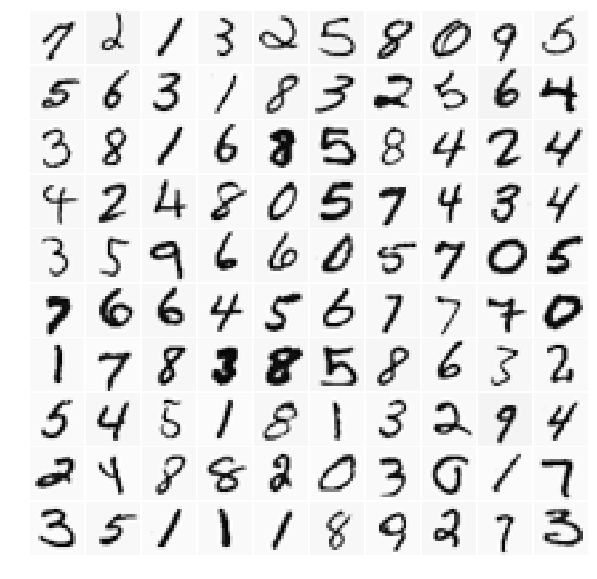

In [38]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# randomly permute examples, to be used for visualizing one 
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)


### 2.1 Model representation 

Our neural network is shown in the following figure.

![Neural network](Figures/neuralnetwork.png)

It has 3 layers: an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y. 

You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained by us. These are stored in `ex3weights.mat`. The following cell loads those parameters into  `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [39]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary 
weights = loadmat(os.path.join('Data', 'ex3weights.mat'))

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

<a id="section4"></a>
### 2.2 Feedforward Propagation and Prediction

Now you will implement feedforward propagation for the neural network. You will need to complete the code in the function `predict` to return the neural network’s prediction. You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $\left( h_\theta(x) \right)_k$.

<div class="alert alert-box alert-warning">
**Implementation Note:** The matrix $X$ contains the examples in rows. When you complete the code in the function `predict`, you will need to add the column of 1’s to the matrix. The matrices `Theta1` and `Theta2` contain the parameters for each unit in rows. Specifically, the first row of `Theta1` corresponds to the first hidden unit in the second layer. In `numpy`, when you compute $z^{(2)} = \theta^{(1)}a^{(1)}$, be sure that you index (and if necessary, transpose) $X$ correctly so that you get $a^{(l)}$ as a 1-D vector.
</div>
<a id="predict"></a>

In [64]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.
    
    Parameters
    ----------
    Theta1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)
    
    Theta2: array_like
        Weights for the second layer in the neural network. 
        It has shape (output layer size x 2nd hidden layer size)
    
    X : array_like
        The image inputs having shape (number of examples x image dimensions).
    
    Return 
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned neural
    network. You should set p to a vector containing labels 
    between 0 to (num_labels-1).
     
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the  max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index
    of the max for each row.
    
    Note
    ----
    Remember, we have supplied the `sigmoid` function in the `utils.py` file. 
    You can use this function by calling `utils.sigmoid(z)`, where you can 
    replace `z` by the required input variable to sigmoid.
    """
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    # useful variables
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly 
    p = np.zeros(X.shape[0])

    # ====================== YOUR CODE HERE ======================
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    H1 = utils.sigmoid(X.dot(Theta1.T))
    H1 = np.concatenate([np.ones((H1.shape[0],1)), H1],axis=1)
    H2 = sigmoid(H1.dot(Theta2.T))
    p = np.argmax(H2,axis =1)



    # =============================================================
    return p

Once you are done, call your predict function using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the accuracy is about 97.5%.

In [63]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

TypeError: data type not understood

After that, we will display images from the training set one at a time, while at the same time printing out the predicted label for the displayed image. 

Run the following cell to display a single image the the neural network's prediction. You can run the cell multiple time to see predictions for different images.

In [ ]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')

*You should now submit your solutions.*

In [ ]:
grader[4] = predict
grader.grade()